In [578]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

df = pd.read_csv('../LSTM-OHLC/TSLA.csv')
df = df[::-1]
df = df.reset_index()
df.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,3285,6/29/2010,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,3284,6/30/2010,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,3283,7/1/2010,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,3282,7/2/2010,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,3281,7/6/2010,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


<Axes: >

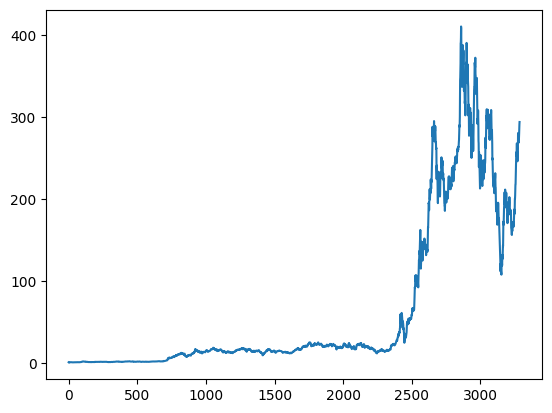

In [579]:
OHLC_avg = df[['Open', 'High', 'Low', 'Close']].mean(axis = 1)
OHLC_avg.plot()

In [580]:
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1))
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [581]:
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [582]:
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [583]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [584]:
step_size = 1
model = Sequential()
model.add(LSTM(64, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(32))
model.add(Dense(1))

model = Sequential()
model.add(LSTM(64, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(32))
model.add(Dense(1))

model = Sequential()
model.add(LSTM(64, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(32))
model.add(Dense(1))

model = Sequential()
model.add(LSTM(64, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, epochs=1, batch_size=5, verbose=1)
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

26/26 [==============================] - 0s 2ms/step


Train RMSE: 0.69
Test RMSE: 9.44


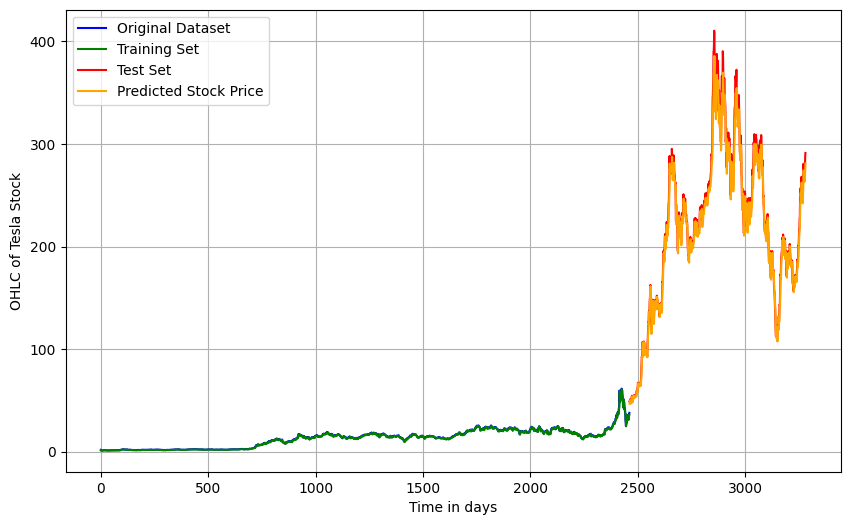

In [585]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

# Plotting the graph
plt.figure(figsize=(10, 6))

# Plot original training data
plt.plot(trainY[0], label='Original Dataset', color='blue')

# Plot predicted training data
trainPredictPlot = np.empty_like(trainY[0])
trainPredictPlot[:] = np.nan
trainPredictPlot[:len(trainPredict)] = trainPredict[:, 0]
plt.plot(trainPredictPlot, label='Training Set', color='green')

# Plot original testing data
plt.plot(range(len(trainY[0]), len(trainY[0]) + len(testY[0])), testY[0], label='Test Set', color='red')

# Plot predicted testing data
testPredictPlot = np.empty_like(testY[0])
testPredictPlot[:] = np.nan
testPredictPlot[:len(testPredict)] = testPredict[:, 0]
plt.plot(range(len(trainY[0]), len(trainY[0]) + len(testPredict)), testPredictPlot, label='Predicted Stock Price', color='orange')

# Add labels and title
plt.xlabel('Time in days')
plt.ylabel('OHLC of Tesla Stock')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

1/1 [==============================] - 0s 25ms/step


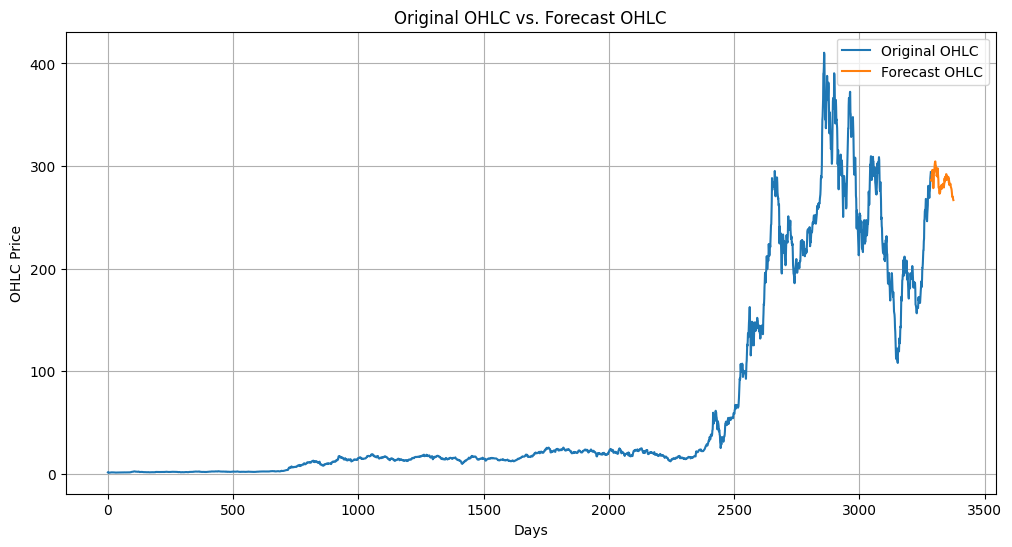

In [586]:
# Model definition
model3 = Sequential()
model3.add(LSTM(64, input_shape=(1, step_size), return_sequences=True))
model3.add(LSTM(32))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')

# Create a copy of OHLC_avg to keep original data intact
new_OHLC_avg = OHLC_avg.copy()

# Forecast OHLC for next 90 days
for i in range(90):
    trainX3, trainY3 = new_dataset(new_OHLC_avg, 1)
    trainX3 = np.reshape(trainX3, (trainX3.shape[0], 1, trainX3.shape[1]))
    model3.fit(trainX3, trainY3, epochs=5, batch_size=1, verbose=0)

    last_val = new_OHLC_avg[-1]
    next_val = model3.predict(np.reshape(last_val, (1, 1, 1)))
    new_OHLC_avg = np.append(new_OHLC_avg, next_val[0])
    new_OHLC_avg = new_OHLC_avg.reshape(-1, 1)

# Inverse transform scaled OHLC_avg and next_val
next_val = scaler.inverse_transform(new_OHLC_avg[-90:])
OHLC_avg = scaler.inverse_transform(OHLC_avg)

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(OHLC_avg, label='Original OHLC')
plt.plot(np.arange(len(OHLC_avg), len(OHLC_avg) + len(next_val)), next_val, label='Forecast OHLC')
plt.xlabel('Days')
plt.ylabel('OHLC Price')
plt.legend()
plt.title('Original OHLC vs. Forecast OHLC')
plt.grid(True)
plt.show()